# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import combinations
import random
import re

In [2]:
pal = 'deep'
st = 'whitegrid'
fig_size = {'figure.figsize':(10, 8)}

sns.set_theme(context='notebook',
              style= st,
              palette= pal,
              font='sans-serif',
              font_scale=1,
              color_codes=True,
              rc= fig_size)

In [3]:
df = pd.read_csv('../data/raw_data/lyrics-data.csv')
df.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [4]:
df_art = pd.read_csv('../data/raw_data/artists-data.csv')
df_art.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [5]:
df = df[df['language']=='en'].reset_index(drop=True)

## Class Label Preparation: Genre

In [6]:
genres = []
for artist_id in tqdm(df['ALink']):    
    artist_row = df_art[df_art['Link']==artist_id].reset_index()
    try:
        genres_in_artist = artist_row['Genres'][0].split('; ')        
    except:
        genres_in_artist = []
    genres.append(genres_in_artist)

100%|██████████| 191814/191814 [03:30<00:00, 912.36it/s] 


In [7]:
df.drop(columns = ['ALink', 'SName', 'SLink', 'language'], inplace=True)
df.rename(columns={'Lyric': 'lyrics'}, inplace=True)

In [8]:
genres = pd.Series(genres)
# Convert nested list into one-hot-encoding
mlb = MultiLabelBinarizer()
genres_one_hot = pd.DataFrame(mlb.fit_transform(genres),
                    columns=mlb.classes_,
                    index=genres.index)
genres_one_hot.head()

,Axé,Black Music,Blues,Bossa Nova,COLETÂNEA,Chillout,Classic Rock,Clássico,Country,Dance,...,Soul Music,Surf Music,Tecnopop,Trance,Trap,Trilha Sonora,Trip-Hop,Tropical House,Velha Guarda,World Music
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
genres_one_hot.sum().sort_values(ascending=False)[:10]

Rock           63717
Pop            33571
Pop/Rock       26360
Heavy Metal    21759
Hip Hop        20902
Indie          20134
Romântico      17947
Hard Rock      17250
Rap            17114
R&B            15581
dtype: int64

In [10]:
# Keep only the 8 most frequent genres (some of them will also be merged)
genres2keep = genres_one_hot.sum().sort_values(ascending=False)[:9].keys()

# Format labels
format_label = lambda s: s.lower().replace(' ', '-').replace('/', '-')

genres_one_hot = genres_one_hot[genres2keep]
genres_one_hot.rename(columns = dict([(
    genre_label, format_label(genre_label)) 
    for genre_label in genres_one_hot.keys()]), inplace=True)

In [11]:
df = pd.concat([df, genres_one_hot], axis=1)

In [12]:
genre_labels = [label for label in df.keys() if label != 'lyrics']

# Remove lyrics that do not fit into the main genres
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [13]:
jaccard_similarity = lambda x, y: np.logical_and(x, y).sum() / np.logical_or(x, y).sum()

genre_pairs = list(combinations(genre_labels, 2))

genre_similarities = [jaccard_similarity(df[genre_pair[0]], df[genre_pair[1]]) 
    for genre_pair in genre_pairs]

sorted(list(zip(genre_pairs, genre_similarities)),
    reverse=True, key=lambda x: x[1])[:20]

[(('hip-hop', 'rap'), 0.5317297231959386),
 (('heavy-metal', 'hard-rock'), 0.29537756525204223),
 (('rock', 'hard-rock'), 0.2094735898661568),
 (('pop', 'pop-rock'), 0.20258854218922445),
 (('rock', 'heavy-metal'), 0.15670672296200064),
 (('pop', 'romântico'), 0.13970311704975333),
 (('rock', 'pop-rock'), 0.13782431852057703),
 (('pop-rock', 'romântico'), 0.10936678434612784),
 (('rock', 'indie'), 0.10295433021151215),
 (('pop', 'hip-hop'), 0.058550330353672755),
 (('rock', 'romântico'), 0.0391540585593037),
 (('pop-rock', 'indie'), 0.03575486199291586),
 (('pop', 'rap'), 0.03301742586365026),
 (('pop', 'indie'), 0.02956118321415563),
 (('rock', 'pop'), 0.029502645502645503),
 (('indie', 'romântico'), 0.029299672946455118),
 (('pop-rock', 'hard-rock'), 0.012772875058058523),
 (('rock', 'hip-hop'), 0.007644950403086559),
 (('indie', 'hard-rock'), 0.007030681787571048),
 (('romântico', 'hard-rock'), 0.005513655582219175)]

In [14]:
# Merge together rap and hip hop
df['rap'] = np.logical_or(df['rap'], df['hip-hop']).replace({True: 1, False: 0})
# Drop columns
df.drop(columns=['romântico'], inplace=True)
df.drop(columns=['hip-hop'], inplace=True)
# Remove again lyrics that do not fit into the genres kept
genre_labels = [label for label in df.keys() if label != 'lyrics']
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [15]:
# Get unique labels and compute value counts
df[df[genre_labels].sum(axis=1) == 1][genre_labels].sum(axis=0)

rock           26201
pop            17770
pop-rock        6011
heavy-metal     8447
indie           9468
hard-rock       1460
rap            20185
dtype: int64

In [16]:
# Drop songs with multiple genres
df.drop(df[df[genre_labels].sum(axis=1) > 1].index, inplace=True)
# Keep only rock, pop and rap lyrics:
# 1) Remove columns
df.drop(columns=['pop-rock','heavy-metal','indie','hard-rock'], inplace=True)
# 2) Remove rows
genre_labels = [label for label in df.keys() if label != 'lyrics']
df.drop(df[df[genre_labels].sum(axis=1) == 0].index, inplace=True)

In [17]:
# Duplicates are songs with multiple artists (e.g. a featuring)
# Remove duplicates having the same genre
print(f'Duplicates with the same genre: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
# Remove lyrics with different genres among duplicates:
print(f'Duplicates with different genres: {df.duplicated(subset="lyrics").sum()}')
df.drop_duplicates(subset="lyrics", keep=False, inplace=True)

Duplicates with the same genre: 349
Duplicates with different genres: 90


In [18]:
df[genre_labels].sum(axis=0)

rock    26082
pop     17576
rap     19969
dtype: int64

In [19]:
df.reset_index(inplace=True, drop=True)

## Text Cleaning

In [20]:
rand = random.choice(df['lyrics'])
rand

"A man took an ad on T.V.\nTo enrol in the police academy\nHe's very talented, outstanding proof\nFrom his clean-cut apperance to the shine on his boots\nWhen it comes to graduation, he's number one\nAn expert with a rifle and also a gun\nThree weeks on the beat and his weak nerves crack\nAnd fires four warning shots into a kid's back\n\nKILLERS! these are the killers\nKILLERS! the coldhearted killers\nKILLERS! bloodthirsty killers\nKILLERS! beware of the killers\n\nA young girl marries an older man\nWith more money than you can understand\nHe smouthers her with pearls and jewellery\nAnd they both seemed as happy as they could be\nBut three months later, she's sad but content\nSeems he had an unexpected accident\nThe girl said he would be hard to forget\nAs the papers interviewed her while she flew his jet\n\nKILLERS! these are the killers\nKILLERS! she was the killer\nKILLERS! the coldhearted killers\nKILLERS! beware of the killers\n\nIt's time for all to work together for peace\n'Cau

In [21]:
def clean_text(lyrics):
    lyrics = re.sub(r'\((.+?)?\)', '', lyrics)
    lyrics = re.sub(r'\[(.+?)?\]', '', lyrics)
    lyrics = re.sub(r'\n+', '\n', lyrics)
    return lyrics

In [22]:
clean_text(rand)

"A man took an ad on T.V.\nTo enrol in the police academy\nHe's very talented, outstanding proof\nFrom his clean-cut apperance to the shine on his boots\nWhen it comes to graduation, he's number one\nAn expert with a rifle and also a gun\nThree weeks on the beat and his weak nerves crack\nAnd fires four warning shots into a kid's back\nKILLERS! these are the killers\nKILLERS! the coldhearted killers\nKILLERS! bloodthirsty killers\nKILLERS! beware of the killers\nA young girl marries an older man\nWith more money than you can understand\nHe smouthers her with pearls and jewellery\nAnd they both seemed as happy as they could be\nBut three months later, she's sad but content\nSeems he had an unexpected accident\nThe girl said he would be hard to forget\nAs the papers interviewed her while she flew his jet\nKILLERS! these are the killers\nKILLERS! she was the killer\nKILLERS! the coldhearted killers\nKILLERS! beware of the killers\nIt's time for all to work together for peace\n'Cause every

In [23]:
df['lyrics'] = [clean_text(lyrics) for lyrics in tqdm(df['lyrics'])]

100%|██████████| 63627/63627 [00:02<00:00, 28309.46it/s]


In [24]:
# Split lyrics in verses consider \n as sep, filter empty element in list (it's the result of '\n\n')
df['lyrics'] = list(map(lambda x: [verse for verse in x.split('\n') if verse], df['lyrics']))

In [25]:
# count number of verses
df['verses'] = df['lyrics'].apply(len)

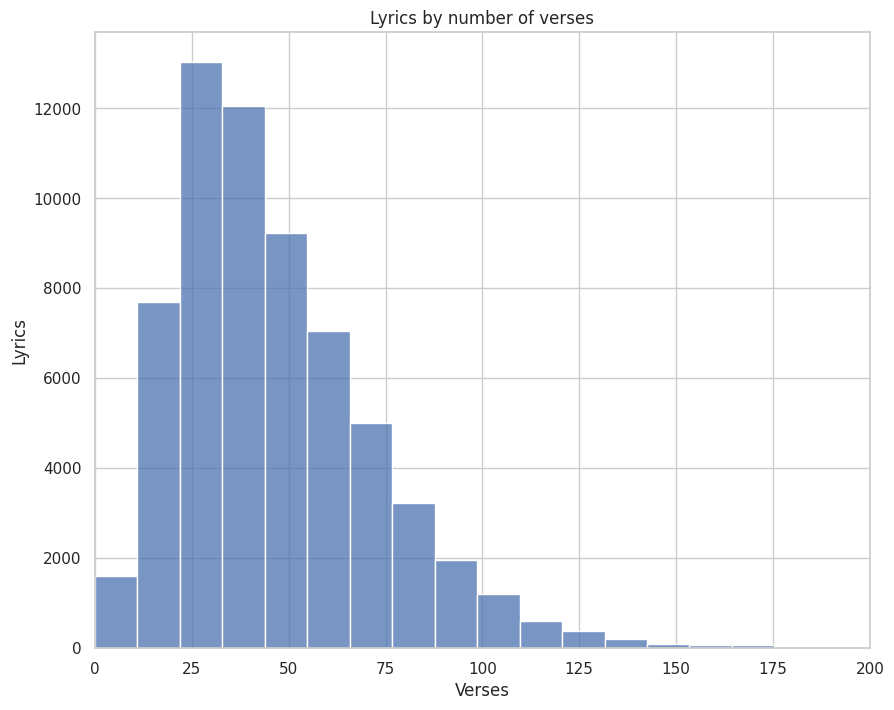

In [26]:
fig, ax = plt.subplots()
ax = sns.histplot(data=df, x='verses', bins=50)
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
# There seems to be outliers
ax.set_xlim([0, 200])
plt.show()

In [27]:
# Remove short lyrics
df = df[df['verses']>20]
# Truncate long lyrics
df['lyrics'] = list(map(lambda x: x[:100] if len(x) > 100 else x, df['lyrics']))

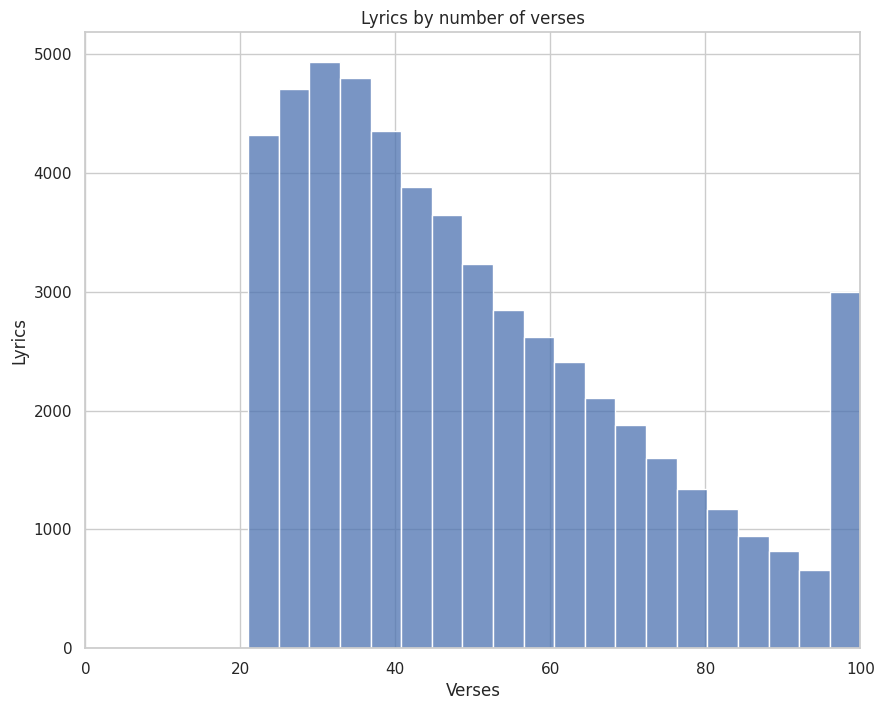

In [28]:
# count number of verses
df['verses'] = df['lyrics'].apply(len)
# Plot distribution
fig, ax = plt.subplots()
ax = sns.histplot(data=df, x='verses', bins=20)
ax.set_xlabel('Verses')
ax.set_ylabel('Lyrics')
ax.set_title('Lyrics by number of verses')
ax.set_xlim([0, 100])
plt.show()

In [29]:
# Map again dummy variables to labels
df['genre'] = df[['rock', 'pop', 'rap']].apply(lambda x: 'rock' if x[0] == 1 else ('pop' if x[1] == 1 else ('rap' if x[2] == 1 else None)), axis=1)

# Drop dummy variables
df = df.drop(columns=['rock', 'pop', 'rap'])

df.head()

,lyrics,verses,genre
0,"[I feel so unsure, As I take your hand and lea...",47,pop
1,"[Don't let them fool, ya, Or even try to schoo...",28,pop
2,"[Baby, let's cruise, away from here, Don't be ...",26,pop
3,"[Know it sounds funny, But, I just can't stand...",31,pop
4,"[You've got that look again, The one I hoped I...",35,pop


In [30]:
df['genre'].value_counts()

rock    20017
rap     19116
pop     16119
Name: genre, dtype: int64

In [31]:
df.shape

(55252, 3)

## Sampling

In [32]:
# Create samples taking 100 lyrics by genre
genre_sample100 = [df[df['genre'] == genre_label].sample(n=50, weights='verses') for genre_label in genre_labels]

df_eval = pd.concat(genre_sample100).drop(columns=['verses']).reset_index()

df_eval.to_csv('../data/lyrics_evaluation.csv', index=False)

In [33]:
df.drop(columns=['verses'], inplace=True)
# Save df
df.to_csv('../data/lyrics.csv', index=False)

## Evaluation Dataset Preparation

In [34]:
import pandas as pd
import numpy as np
import random
import ast
from tqdm import tqdm
from textattack.augmentation import EmbeddingAugmenter
from faker import Faker
from sklearn.model_selection import train_test_split

2023-01-04 22:20:27.906965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-04 22:20:27.906994: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-04 22:20:27.907017: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mattiapggioli-ThinkPad-E595): /proc/driver/nvidia/version does not exist


In [35]:
df = pd.read_csv('../data/lyrics_evaluation.csv')

In [36]:
df.head()

,index,lyrics,genre
0,58782,"[""We can't decide if we are fallen"", 'Because ...",rock
1,8610,"['I tried to talk her into it', 'And I tried.....",rock
2,62414,"['They came across, on 1 FM', 'Two unattractiv...",rock
3,20879,"[""Well my baby's gone, so's summer"", 'And it b...",rock
4,56928,"['Do do do do', 'Do do do do', 'Do do do do', ...",rock


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   150 non-null    int64 
 1   lyrics  150 non-null    object
 2   genre   150 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


In [38]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))

In [39]:
emb_augmenter = EmbeddingAugmenter(pct_words_to_swap=0.5, transformations_per_example=1)

In [40]:
def perturbate_lyrics(lyrics):    
    emb_augmenter = EmbeddingAugmenter(pct_words_to_swap=0.5, transformations_per_example=1)
    fake = Faker()
    perturbated_lyrics = []
    for verse in lyrics:
        x = random.randint(1, 3)
        if x == 1:
            # Replace verse with the augmented one using EmbeddingAugmenter
            perturbated_lyrics.append(emb_augmenter.augment(verse)[0])
        elif x == 2:
            # Replace verse with a random one from the lyrics and apply augmentation
            perturbated_lyrics.append(emb_augmenter.augment(random.choice(lyrics))[0])
        else:
            # Replace verse with a random sentence
            perturbated_lyrics.append(fake.sentence())
    return perturbated_lyrics

In [41]:
eg_lyrics = random.choice(df['lyrics'])

eg_aug_lyrics = emb_augmenter.augment_many(eg_lyrics)
eg_pert_lyrics = perturbate_lyrics(eg_lyrics)

print('Original lyrics:')
print(eg_lyrics[:20])
print()
print('Augmented lyrics:')
print(eg_aug_lyrics[:20])
print()
print('Perturbated lyrics:')
print(eg_pert_lyrics[:20])  

Original lyrics:
['This train is coming back again', 'Extravaganza, you should run and tell a friend', 'Kings and queens are posted at the bar', "Buckin' down, it's time to take it all", 'Walk that walk ', 'Show me how you move it and you', 'Walk that talk ', "Let's just snap in to it", "It's your chance now", 'Girl you better dance now', "It's your time to show it all", 'The spotlight is on you, you better...', 'Work work work work', 'Work work work work', 'Work work work work', 'Work work...Bitch you better work!', 'Work work work work', 'Work work work work', 'Work work work work', 'Work work...Bitch you better work!']

Augmented lyrics:
[['This forming is arrival back again'], ['Extravaganza, you should execute and told a amie'], ['Kings and faggots are positioned at the solicitor'], ["Buckin' down, it's period to taking it all"], ['Walk that stroll '], ['Exhibited me how you budge it and you'], ['Walk that discussions '], ["Let's just snapshot in to it"], ["It's your chances now"]

In [42]:
df1, df2 = train_test_split(df, test_size=0.5, shuffle=True, stratify=df[['genre']])

In [43]:
get_unique_element = lambda x: [one_element_list[0] for one_element_list in x]

df1['comparison_lyrics'] = [get_unique_element(emb_augmenter.augment_many(lyrics)) 
    for lyrics in tqdm(df1['lyrics'])]

df1['similar'] = 1

100%|██████████| 75/75 [03:35<00:00,  2.88s/it]


In [44]:
df2['comparison_lyrics'] = [perturbate_lyrics(lyrics)
    for lyrics in tqdm(df2['lyrics'])]

df2['similar'] = 0

100%|██████████| 75/75 [02:20<00:00,  1.87s/it]


In [45]:
df = pd.concat([df1, df2])

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 142 to 94
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              150 non-null    int64 
 1   lyrics             150 non-null    object
 2   genre              150 non-null    object
 3   comparison_lyrics  150 non-null    object
 4   similar            150 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 7.0+ KB


In [47]:
df.to_csv('../data/lyrics_evaluation.csv', index=False)